In [ ]:
pip install ipympl pandas matplotlib

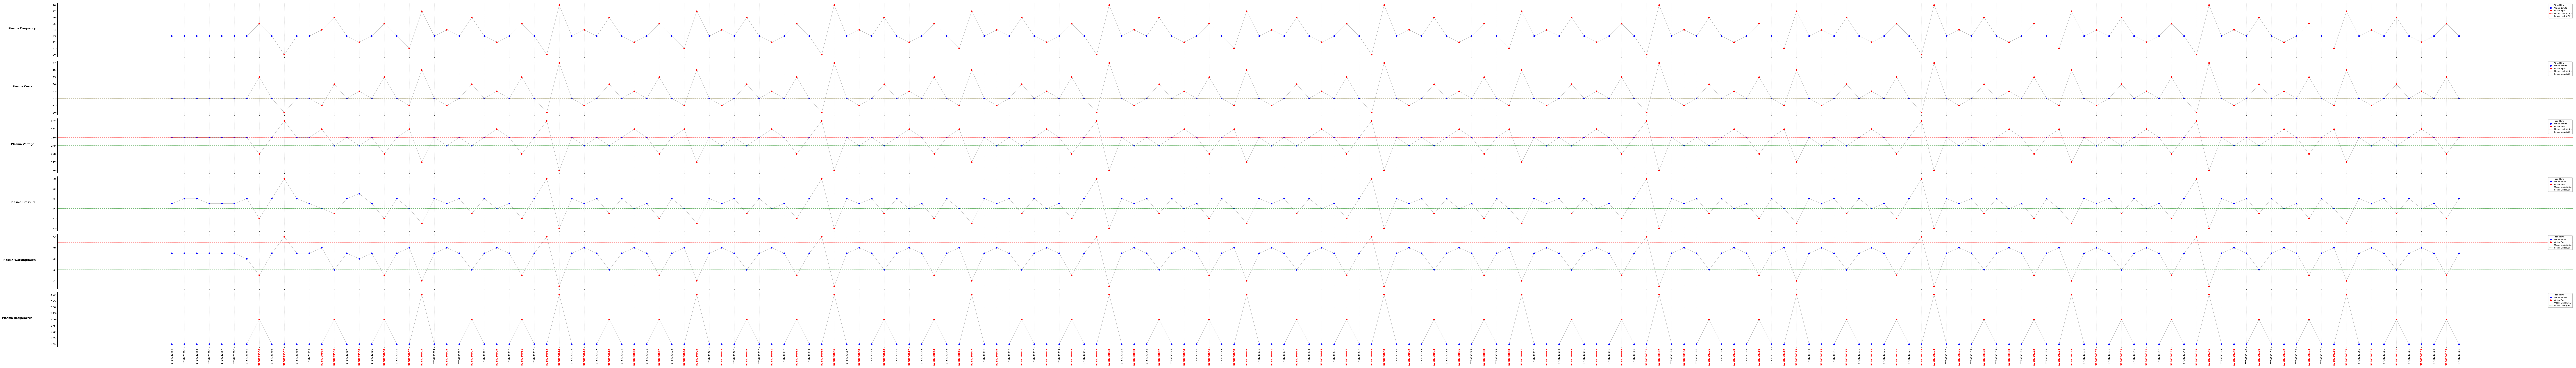

interactive(children=(FloatSlider(value=0.8, description='Spacing:', max=2.0, min=0.5), Output()), _dom_classe…

In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.lines import Line2D

# 1. Load Data
results_df = pd.read_csv('results.csv', encoding='utf-8-sig')
limits_df = pd.read_csv('limits.csv', encoding='utf-8-sig')

# 2. Identify "Global" NOK Parts
results_with_limits = results_df.merge(
    limits_df[['param_name', 'Lower OK', 'Upper OK']], on='param_name', how='left'
)
results_with_limits['is_nok'] = (
    (results_with_limits['result'] < results_with_limits['Lower OK']) | 
    (results_with_limits['result'] > results_with_limits['Upper OK'])
)
nok_part_ids = set(results_with_limits.loc[results_with_limits['is_nok'], 'uniquepart_id'].astype(str))

# 3. Plotting Function
def draw_stacked_chart(gap_size=0.7):
    plt.close('all')
    parameters = limits_df['param_name'].unique()
    num_params = len(parameters)
    unique_ids = results_df[results_df['param_name'] == parameters[0]]['uniquepart_id'].astype(str).tolist()
    
    total_width = max(14, len(unique_ids) * gap_size)
    fig, axes = plt.subplots(num_params, 1, figsize=(total_width, 3.5 * num_params), sharex=True)
    
    if num_params == 1: axes = [axes]

    # Custom Legend Elements
    legend_elements = [
        Line2D([0], [0], color='black', alpha=0.3, lw=1, label='Trend Line'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Within Limits'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Out of Spec'),
        Line2D([0], [0], color='red', lw=1, linestyle='--', label='Upper Limit (USL)'),
        Line2D([0], [0], color='green', lw=1, linestyle='--', label='Lower Limit (LSL)')
    ]

    for i, param in enumerate(parameters):
        ax = axes[i]
        data = results_df[results_df['param_name'] == param].reset_index(drop=True)
        low = limits_df.loc[limits_df['param_name'] == param, 'Lower OK'].values[0]
        high = limits_df.loc[limits_df['param_name'] == param, 'Upper OK'].values[0]

        # Coloring logic
        point_colors = ['blue' if (low <= val <= high) else 'red' for val in data['result']]

        # Plotting
        ax.plot(data.index, data['result'], color='black', linewidth=1, alpha=0.3, zorder=1)
        ax.scatter(data.index, data['result'], c=point_colors, s=50, edgecolors='white', linewidth=0.5, zorder=2)
        
        # Limit Lines
        ax.axhline(y=high, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.axhline(y=low, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
        
        # Legend for each parameter (Top Right)
        ax.legend(handles=legend_elements, loc='upper right', fontsize=8, frameon=True, shadow=True)

        # Labels & Aesthetics
        ax.set_ylabel(f"{param}", fontweight='bold', rotation=0, labelpad=70, ha='right', fontsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='x', linestyle=':', alpha=0.4)

    # Final X-Axis Formatting
    last_ax = axes[-1]
    last_ax.set_xticks(range(len(unique_ids)))
    last_ax.set_xticklabels(unique_ids, rotation=90)
    
    for tick_label in last_ax.get_xticklabels():
        if tick_label.get_text() in nok_part_ids:
            tick_label.set_color('red')
            tick_label.set_weight('bold')
    
    plt.tight_layout()
    plt.show()

# 4. Interactive Display
widgets.interact(draw_stacked_chart, gap_size=widgets.FloatSlider(
    value=0.8, min=0.5, max=2.0, step=0.1, description='Spacing:'));